In [23]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.cluster import KMeans
from collections import Counter
import pickle

In [25]:
class ColorExtractionPipeline:
    def __init__(self, n_clusters=10):
        self.n_clusters = n_clusters  # Allow customization of the number of clusters

    def get_labels(self, pixels):
        # Apply KMeans clustering for color extraction
        clf = KMeans(n_clusters=self.n_clusters)
        labels = clf.fit_predict(pixels)
        return labels, clf

    def RGB2HEX(self, color):
        # Convert RGB color to HEX format
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

    def HEX2RGB(self, hex_color):
        # Convert HEX color to RGB format
        hex_color = hex_color.lstrip('#')
        rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return np.array(rgb_color)

    def extract_colors(self, skin_pixels):
        # Ensure the input is reshaped into 2D (if necessary)
        reshaped_pixels = skin_pixels.reshape(-1, 3)
        labels, clf = self.get_labels(reshaped_pixels)
        
        # Count the occurrences of each label
        counts = Counter(labels)
        
        # Get the cluster centers (dominant colors)
        center_colors = clf.cluster_centers_
        
        # Order the colors by their frequency
        ordered_colors = [center_colors[i] for i in counts.keys()]
        hex_colors = [self.RGB2HEX(ordered_colors[i]) for i in counts.keys()]
        
        # Find the 3 most dominant colors (the ones with max count)
        most_dominant_indices = sorted(counts, key=counts.get, reverse=True)[:10]
        dominant_colors = [center_colors[i] for i in most_dominant_indices]

        return hex_colors, dominant_colors, center_colors

    def closest_to_white(self, center_colors):
        # Find the color closest to white
        closest_color_to_white = min(center_colors, key=lambda c: np.linalg.norm(c - [255, 255, 255]))
        return closest_color_to_white  # Return as RGB

    def average_of_colors(self, colors):
        # Calculate the average color of the given colors
        avg_color = np.mean(colors, axis=0)
        return avg_color

    def weighted_average(self, color1, color2, weight1, weight2):
        # Calculate the weighted average of two colors
        weighted_avg = (color1 * weight1) + (color2 * weight2)
        return weighted_avg

    def __call__(self, skin_pixels):
        # Call the extract_colors function and return its output
        return self.extract_colors(skin_pixels)


color_extraction = ColorExtractionPipeline(n_clusters=10)

In [34]:
#make a function to load the image using cv2
def load_image(image_path):
    try:
        return cv2.imread(image_path)
    except:
        print("Error")


#function for detecting faces in the image
def detect_face(image):

    #load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    #As it only works on grey images, convert the image to  greyscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Now detect faces in image
    #scale factor sets scale by which faces are detected
    #min size gives the minimum size that the face detected should be
    #haar cascades works by drawing rectangles for faces so min neighbours specifies minimum number of rectangles there should be
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    #now check if there are any faces detected
    if len(faces) == 0:
        return False
    else:
        #Select the largest face by getting max
        face_detected = max(faces, key=lambda rect: rect[2] * rect[3])  

        #get the x,y, width and height of the face
        x,y,h,w=face_detected

        #Crop the image to get the face
        face = image[y:y+h, x:x+w]

        #return the face
        return face


# Function to get the skin pixels from the image and return them in RGB
def get_skin_tone(image):
    # Convert the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define minimum and maximum values for skin HSV
    lower_hsv = np.array([0, 40, 30], dtype=np.uint8)
    upper_hsv = np.array([25, 255, 255], dtype=np.uint8)
    
    # Create a mask to only get pixels in the specified range
    skin_mask = cv2.inRange(hsv_image, lower_hsv, upper_hsv)
    
    # Apply the mask to the image to detect skin pixels
    skin_pixels_bgr = cv2.bitwise_and(image, image, mask=skin_mask)
    
    # Convert skin pixels from BGR to RGB
    skin_pixels_rgb = cv2.cvtColor(skin_pixels_bgr, cv2.COLOR_BGR2RGB)

    return skin_pixels_rgb


#function to detect white areas in the image
def detect_white_areas(image):
    #Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #Define thresholds for white areas
    lower_white = np.array([0, 0, 200], dtype=np.uint8)
    upper_white = np.array([180, 50, 255], dtype=np.uint8)

    #Create a mask for white areas
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)

    #Detect white areas in the image
    white_areas = cv2.bitwise_and(image, image, mask=white_mask)

    #Calculate the average color of the white areas
    non_zero_pixels = white_areas[white_mask == 255]
    if non_zero_pixels.size > 0:
        avg_color = np.mean(non_zero_pixels, axis=0)
    else:
        avg_color = [0, 0, 0]
        
    return avg_color


class ColorExtractionPipeline:
    def __init__(self, n_clusters=10):
        self.n_clusters = n_clusters  # Allow customization of the number of clusters

    def get_labels(self, pixels):
        # Apply KMeans clustering for color extraction
        clf = KMeans(n_clusters=self.n_clusters)
        labels = clf.fit_predict(pixels)
        return labels, clf

    def RGB2HEX(self, color):
        # Convert RGB color to HEX format
        return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

    def HEX2RGB(self, hex_color):
        # Convert HEX color to RGB format
        hex_color = hex_color.lstrip('#')
        rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return np.array(rgb_color)

    def extract_colors(self, skin_pixels):
        # Ensure the input is reshaped into 2D (if necessary)
        reshaped_pixels = skin_pixels.reshape(-1, 3)
        labels, clf = self.get_labels(reshaped_pixels)
        
        # Count the occurrences of each label
        counts = Counter(labels)
        
        # Get the cluster centers (dominant colors)
        center_colors = clf.cluster_centers_
        
        # Order the colors by their frequency
        ordered_colors = [center_colors[i] for i in counts.keys()]
        hex_colors = [self.RGB2HEX(ordered_colors[i]) for i in counts.keys()]
        
        # Find the 3 most dominant colors (the ones with max count)
        most_dominant_indices = sorted(counts, key=counts.get, reverse=True)[:10]
        dominant_colors = [center_colors[i] for i in most_dominant_indices]

        return hex_colors, dominant_colors, center_colors

    def closest_to_white(self, center_colors):
        # Find the color closest to white
        closest_color_to_white = min(center_colors, key=lambda c: np.linalg.norm(c - [255, 255, 255]))
        return closest_color_to_white  # Return as RGB

    def average_of_colors(self, colors):
        # Calculate the average color of the given colors
        avg_color = np.mean(colors, axis=0)
        return avg_color

    def weighted_average(self, color1, color2, weight1, weight2):
        # Calculate the weighted average of two colors
        weighted_avg = (color1 * weight1) + (color2 * weight2)
        return weighted_avg

    def __call__(self, skin_pixels):
        # Call the extract_colors function and return its output
        return self.extract_colors(skin_pixels)


color_extraction = ColorExtractionPipeline(n_clusters=10)

def final_skin_tone(skin,white,weight=0.5):
    #Convert rbg values to numpy arrays
    skin_rgb = np.array(skin, dtype=float)
    white_rgb = np.array(white, dtype=float)
    true_white = np.array([255, 255, 255], dtype=float)

    if np.array_equal(white_rgb, [0, 0, 0]):
        # If no white areas were detected, return the original skin tone
        corrected_skin_rgb = np.clip(np.round(skin_rgb), 0, 255).astype(int)

    else:
        # Calculate the difference between true white and detected white
        white_difference = true_white - white_rgb

        # Adjust skin tone by subtracting the weighted difference
        corrected_skin = skin_rgb + (white_difference * weight)

        # Clip the values to stay within 0 and 255 and round them
        corrected_skin_rgb = np.clip(np.round(corrected_skin), 0, 255).astype(int)

    return corrected_skin_rgb.astype(int)

#function to combine everything together
def get_tone(image_path):
    image=load_image(image_path)
    face=detect_face(image)

    skin_tone=get_skin_tone(face)
    white=detect_white_areas(image)
    
    #extract colors from class
    colors, dominant_colors, center_colors = color_extraction(skin_tone)
        
    # Get the closest color to white
    closest_to_white_rgb = color_extraction.closest_to_white(center_colors)
        
    # Calculate the average of middle 2 colors to avoid areas like hair
    average_skin_tone = color_extraction.average_of_colors(dominant_colors[3:7])

    # Calculate the average of the 2nd and 3rd dominant colors and the closest to white color
    average_with_lightest = color_extraction.weighted_average(average_skin_tone, closest_to_white_rgb, 0.9, 0.3)

    final_tone=final_skin_tone(average_with_lightest,white)

    # Convert the average skin tone to HEX
    hex_final_skin_tone = color_extraction.RGB2HEX(final_tone)

    #logger.info(image_path + " has skin tone: " + hex_final_skin_tone)

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    # Ensure the colors are reshaped correctly for imshow
    average_skin_tone_img = np.array([[average_skin_tone]], dtype=np.uint8)
    white_img = np.array([[white]], dtype=np.uint8)
    average_with_lightest_img = np.array([[average_with_lightest]], dtype=np.uint8)
    final_tone_img = np.array([[final_tone]], dtype=np.uint8)

    # Plot the dominant colors
    axes[0].imshow(average_skin_tone_img)
    axes[0].axis('off')
    axes[0].set_title("Dominant Tones")

    # Plot closest to white
    axes[1].imshow(white_img)
    axes[1].axis('off')
    axes[1].set_title("Closest to White")

    # Plot average with lightest
    axes[2].imshow(average_with_lightest_img)
    axes[2].axis('off')
    axes[2].set_title("Average with Lightest")

    # Plot final skin tone
    axes[3].imshow(final_tone_img)
    axes[3].axis('off')
    axes[3].set_title("Final Tone")

    # Plot the face
    axes[4].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    axes[4].axis('off')
    axes[4].set_title("Face")

    plt.tight_layout()
    plt.show()



    return hex_final_skin_tone


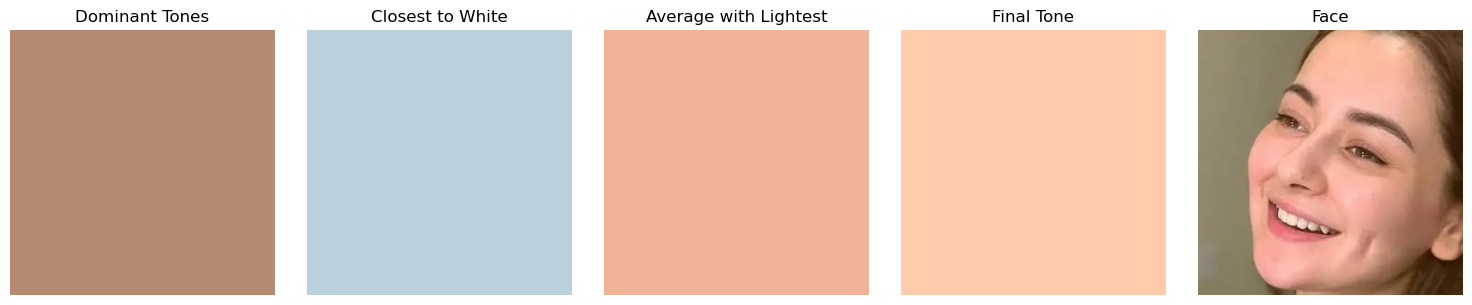

In [62]:
tone=get_tone("faces/8.webp")

In [63]:
def get_x(skin_hex):
    skin_rgb=color_extraction.HEX2RGB(skin_hex)
    skin_red=skin_rgb[0]
    skin_green=skin_rgb[1]
    skin_blue=skin_rgb[2]
    brightness=0.2989 * skin_red + 0.587 * skin_green + 0.114 * skin_blue
    red_ratio=skin_red / skin_red + skin_green + skin_blue
    green_ratio=skin_green / skin_red + skin_green + skin_blue
    blue_ratio=skin_blue / skin_red + skin_green + skin_blue
    normalised_red=skin_red/255.0
    normalised_green=skin_green/255.0
    normalised_blue=skin_blue/255.0
    normalised_brightness=brightness/255.0

    return [[normalised_red, normalised_green, normalised_blue, normalised_brightness , red_ratio, green_ratio, blue_ratio]]


In [66]:
X=get_x(tone)

In [68]:
# Path to your pickle file
pickle_file_path = "web_pages1/random_forest_model.pkl"

# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    loaded_rf_model = pickle.load(file)

# Example: Use the loaded model to make predictions
# Assuming X_test is available
y_pred = loaded_rf_model.predict(X)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [70]:
print(y_pred)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


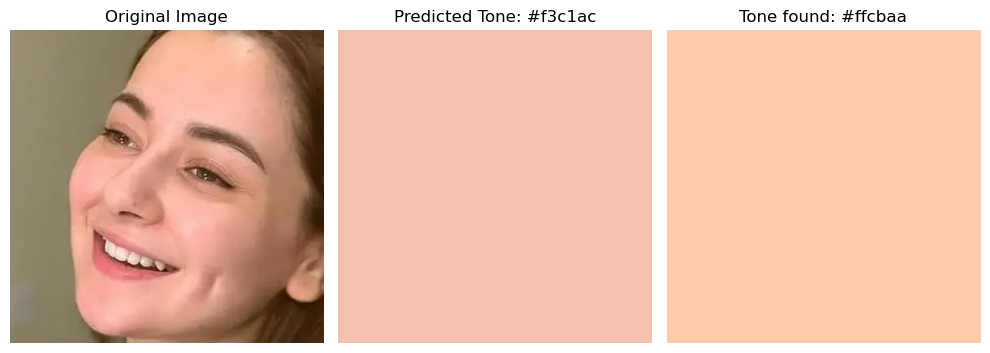

In [72]:
#labels = ["#b78f7d", "#d6ac99", "#f6be97", "#ac8775", "#c19983",  "#fed9ba", "#dba382", "#a47860", "#c7a18e", "#f3c1ac"]

labels=["#a47860","#ac8775","#b78f7d","#c19983","#c7a18e","#d6ac99","#dba382","#f3c1ac","#f6be97","#fed9ba"]

# Get the predicted class index from y_pred
predicted_class = np.argmax(y_pred)

# Get the corresponding hex value for the predicted class
predicted_hex = labels[predicted_class]


image_path = 'faces/8.webp'  # Change this to your image file
image = cv2.imread(image_path)

face= detect_face(image)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the image
axes[0].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title("Original Image")

# Plot the predicted color (skin tone)
axes[1].imshow([[color_extraction.HEX2RGB(predicted_hex)]])  # Display the predicted color as an image
axes[1].axis('off')
axes[1].set_title(f"Predicted Tone: {predicted_hex}")

# Plot the predicted color (skin tone)
axes[2].imshow([[color_extraction.HEX2RGB(tone)]])  # Display the predicted color as an image
axes[2].axis('off')
axes[2].set_title(f"Tone found: {tone}")

plt.tight_layout()
plt.show()

In [74]:
foundations=pd.read_csv("allCategories.csv")
foundations.head()

,brand,product,url,imgSrc,name,categories,specific,hex,lightness
0,BECCA Cosmetics,Ultimate Coverage 24 Hour Foundation,https://www.ulta.com/ultimate-coverage-24-hour...,https://images.ulta.com/is/image/Ulta/2528173s...,shell,gem,1W1,#EFCBA4,0.790196
1,BECCA Cosmetics,Ultimate Coverage 24 Hour Foundation,https://www.ulta.com/ultimate-coverage-24-hour...,https://images.ulta.com/is/image/Ulta/2529033s...,linen,textile,1N1,#F3CEB0,0.821569
2,BECCA Cosmetics,Ultimate Coverage 24 Hour Foundation,https://www.ulta.com/ultimate-coverage-24-hour...,https://images.ulta.com/is/image/Ulta/2549910s...,alabaster,gem,1C1,#F2CBB4,0.827451
3,BECCA Cosmetics,Ultimate Coverage 24 Hour Foundation,https://www.ulta.com/ultimate-coverage-24-hour...,https://images.ulta.com/is/image/Ulta/2528170s...,porcelain,misc,1N2,#F6C8A7,0.809804
4,BECCA Cosmetics,Ultimate Coverage 24 Hour Foundation,https://www.ulta.com/ultimate-coverage-24-hour...,https://images.ulta.com/is/image/Ulta/2529037s...,ivory,"gem, color",1C2,#F0C4AB,0.805882


In [76]:
# Function to calculate Euclidean distance
def euclidean_distance(rgb1, rgb2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(rgb1, rgb2)))

#Function to find the closest makeup shade match
def find_closest_match(skin_hex, df):
    closest_match = None
    min_distance = float('inf')

    # Iterate over each row in the dataframe
    for _, row in foundations.iterrows():
        # Convert Hex color code to RGB
        makeup_rgb = color_extraction.HEX2RGB(row['hex'])  # Assuming 'ColorCode' column contains hex color values
        skin_rgb = color_extraction.HEX2RGB(skin_hex)
        
        # Calculate the Euclidean distance
        distance = euclidean_distance(skin_rgb, makeup_rgb)
        
        # Update the closest match if the current one is closer
        if distance < min_distance:
            min_distance = distance
            closest_match = row
    
    return closest_match


# Find the closest makeup shade match
closest = find_closest_match(tone, foundations)

# Output the closest match details
if closest is not None:
    print(f"Closest match: {closest['brand']} - {closest['product']} (Name: {closest['name']})")
else:
    print("No match found")

Closest match: Clinique - Stay-Matte Sheer Pressed Powder (Name: oat)


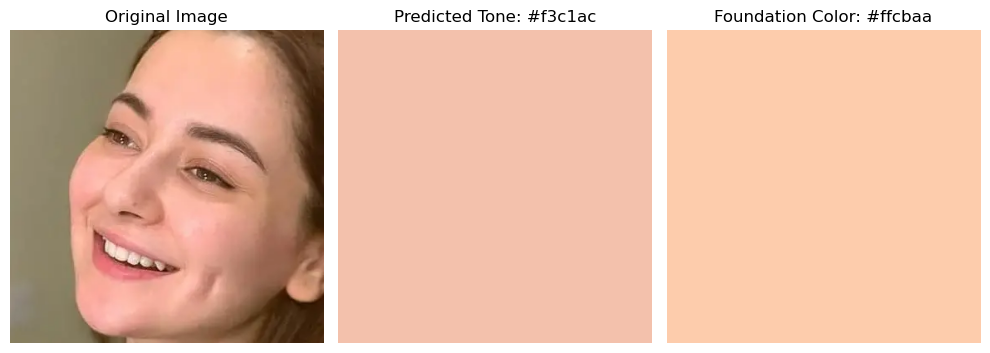

In [80]:
# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the image
axes[0].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title("Original Image")

# Plot the predicted color (skin tone)
axes[1].imshow([[color_extraction.HEX2RGB(predicted_hex)]])  # Display the predicted color as an image
axes[1].axis('off')
axes[1].set_title(f"Predicted Tone: {predicted_hex}")

# Plot the predicted color (skin tone)
axes[2].imshow([[color_extraction.HEX2RGB(closest['hex'])]])  # Display the predicted color as an image
axes[2].axis('off')
axes[2].set_title(f"Foundation Color: {tone}")

plt.tight_layout()
plt.show()